In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0

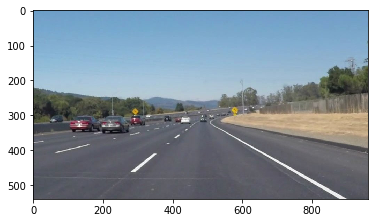

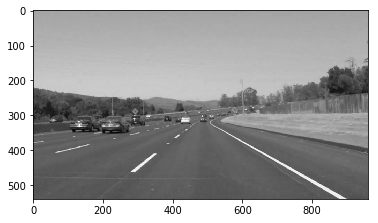

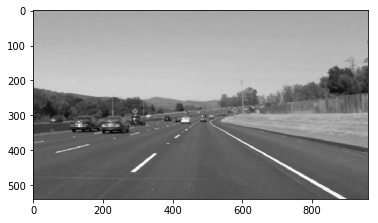

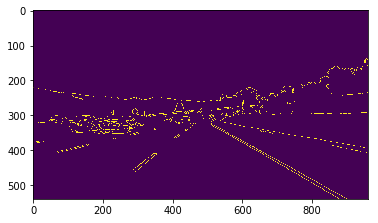

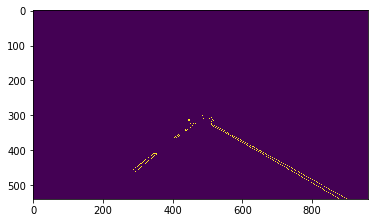

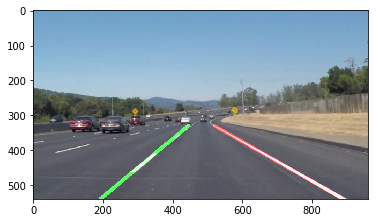

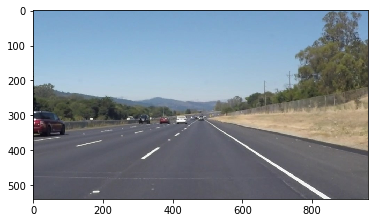

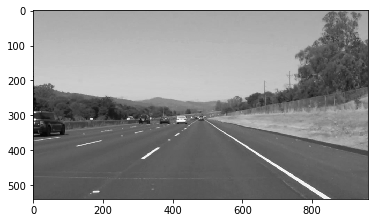

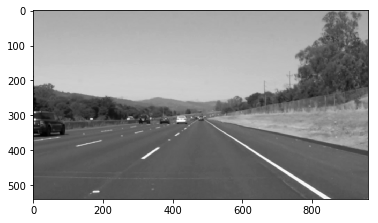

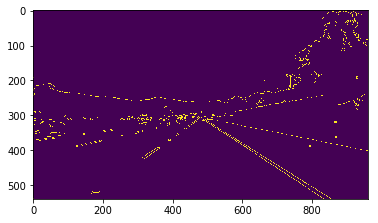

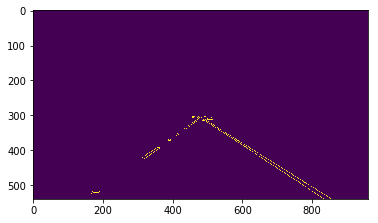

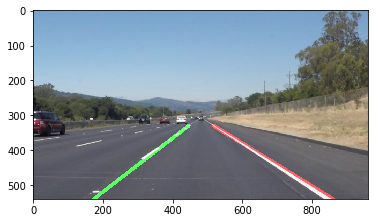

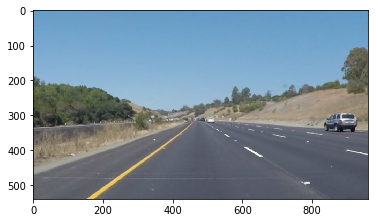

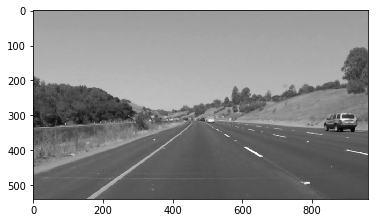

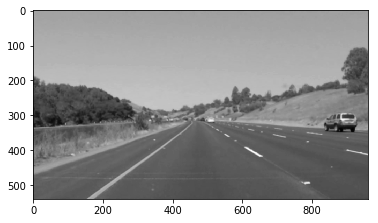

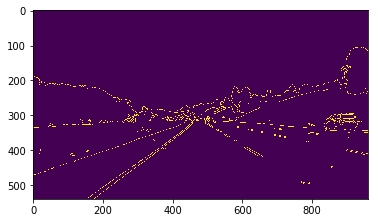

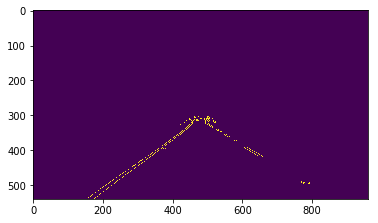

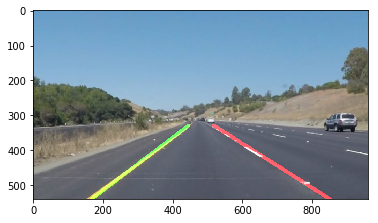

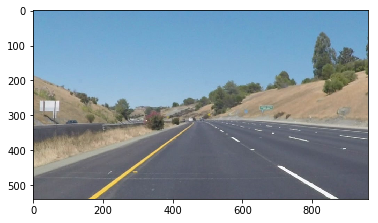

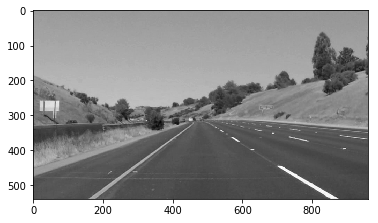

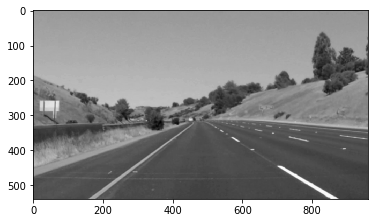

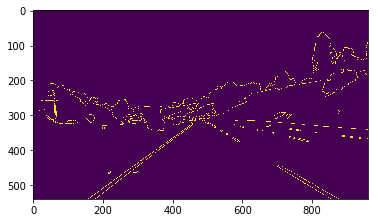

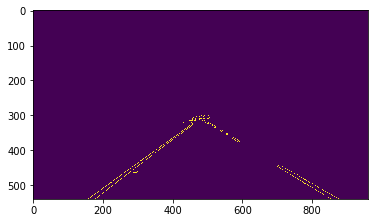

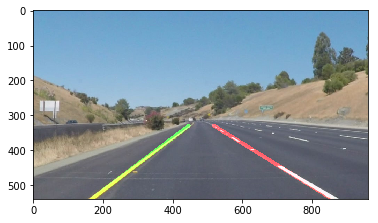

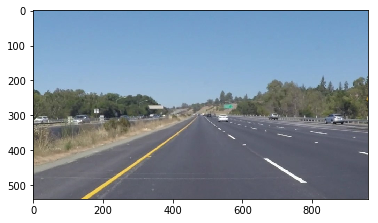

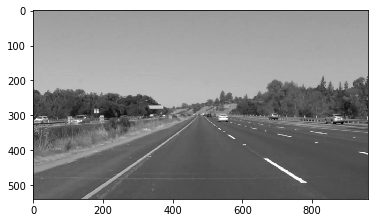

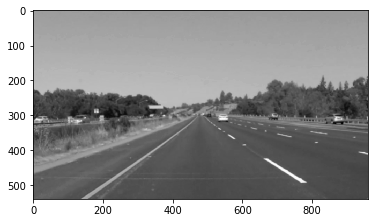

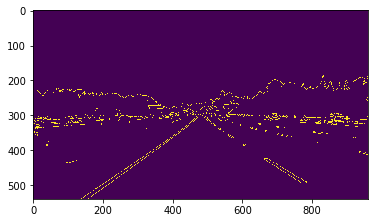

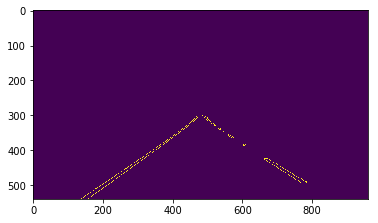

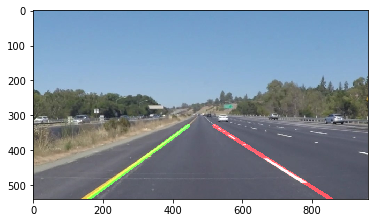

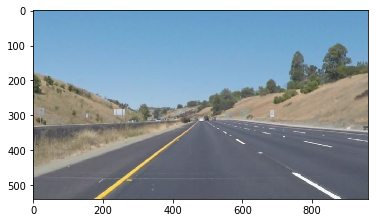

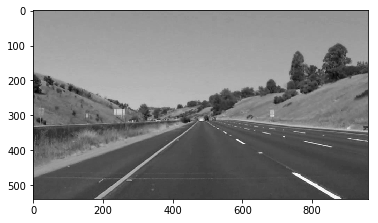

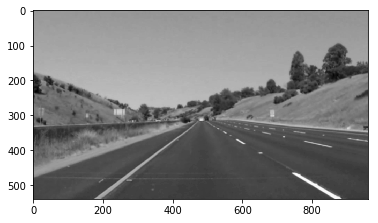

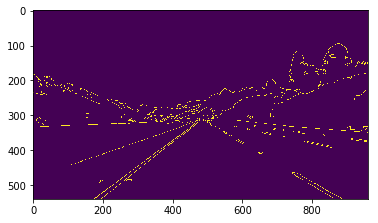

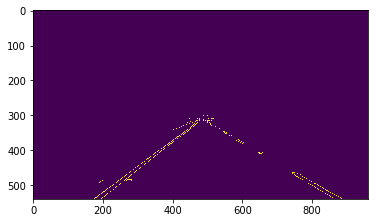

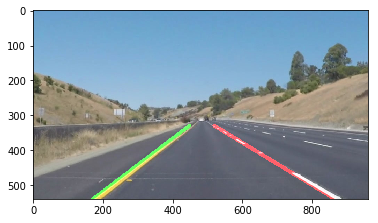

In [8]:
def vertices(img):
    left_bottom = [120, 540]
    left_top = [460, 300]
    right_top = [500, 300]
    right_bottom = [900, 540]
    return np.array([[left_bottom, left_top, right_top, right_bottom, left_bottom]], dtype=np.int32)

def canny_transform(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def midpoint(line):
    for x1,y1,x2,y2 in line:
        point = ((x1+x2)/2),((y1+y2)/2)
        return point

def divide_into_left_right(midpoints, width):
    mid = width / 2
    left = [(int(point[0]),int(point[1])) for point in midpoints if point[0] < mid]
    right = [(int(point[0]),int(point[1])) for point in midpoints if point[0] >= mid]
    left = [(point[0],point[1]) for point in midpoints if point[0] < mid]
    right = [(point[0],point[1]) for point in midpoints if point[0] >= mid]

    sort_function = lambda x: x[0]
    left.sort(key=sort_function)
    right.sort(key=sort_function)
    return left, right

def get_hough_lines(canny):
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 3     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments
    return cv2.HoughLinesP(canny, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

def draw_line_of_points(points, line_image, color = (0,0,255)):
    previous_point = None
    for point in points:
        if previous_point is None:
            previous_point = point
            continue
        cv2.arrowedLine(line_image, previous_point, point, color, 5)
        previous_point = point

def get_line_func_for_points(points):
    x = np.array([a[0] for a in points])
    y = np.array([a[1] for a in points])
    
    m, b = np.polyfit(x,y,1)

    return m, b
    return np.poly1d(fit), x, y

def draw_line_for_points(image, points, base, horizon, previous_mb=None, color=(255,0,0)):
    m, b = get_line_func_for_points(points)
    if previous_mb is not None:
        smoothing = 1
        p_m, p_b, = previous_mb
        m = (m*smoothing + p_m)/(smoothing+1)
        b = (b*smoothing + p_b)/(smoothing+1)
    base_point = (int(calc_x(m,b, base)), base)
    horizon_point = (int(calc_x(m,b, horizon)), horizon)
    cv2.line(image,base_point, horizon_point,color,10)
    return m, b
    
def calc_x(m, b, y):
    return (y - b)/m

def calc_y(m, b, x):
    return m*x+b

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def handle_image(image):
    global previous_mb_left, previous_mb_right
    
    # Turn image to grey scale
    grey = grayscale(image)
    # Run a gaussian blur on the image.
    blurred = gaussian_blur(grey, 5)
    # Run the canny transform
    canny = canny_transform(blurred, 50, 150)
    # Cut out the relevant section
    region = region_of_interest(canny, vertices(image))

    # Generate the hough_lines from the region restricted canny transform
    hough_lines = get_hough_lines(region)
    
    # Get the middle points of all lines
    midpoints = [midpoint(line) for line in hough_lines]

    # Split the points into two arrays down the middle
    left_points, right_points = divide_into_left_right(midpoints, image.shape[1])
    
    # Create a image to draw on top of.
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Use a linear regression on each set of points to get a line corresponding to each lane marker. 
    # Feed in the result from the previous run so we can smooth over it.
    print(line_image)
    previous_mb_left = draw_line_for_points(line_image, left_points, 540, 330, previous_mb=previous_mb_left,
                                                color=(0,255,0))
    
    previous_mb_right = draw_line_for_points(line_image, right_points, 540, 330,
                                                previous_mb=previous_mb_right)

    plt.figure()
    plt.imshow(grey, cmap='gray')
    plt.figure()
    plt.imshow(blurred, cmap='gray')
    plt.figure()
    plt.imshow(canny)
    plt.figure()
    plt.imshow(region)
    plt.figure()
    plt.imshow(line_image)

    # Combine the lines with the raw image.
    return weighted_img(image, line_image)

def run_video(input, output):
    clip2 = VideoFileClip(input)
    yellow_clip = clip2.fl_image(handle_image)
    %time yellow_clip.write_videofile(output, audio=False)

def run_test_images():
    for img_path in os.listdir("test_images/"):
        path = "test_images/" + img_path
        image = mpimg.imread(path)
        plt.figure()
        plt.imshow(image)
        plt.figure()
        plt.imshow(handle_image(image))
    
previous_mb_left = None
previous_mb_right = None
    
run_test_images()
input = 'solidYellowLeft.mp4'
output = './yellow_output.mp4'
#run_video(input, output)

In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))